In [ ]:
'''
小鱼儿老师：课程14-编写强化学习环境进阶 https://www.bilibili.com/video/BV1bY41147Fz/?spm_id_from=333.999.0.0&vd_source=eb79911dba31f65406585397357ca033
'''

In [1]:
import numpy as np
import cv2
from PIL import Image
import pickle
import matplotlib.pyplot as plt
import time
import os
from matplotlib import style
style.use('ggplot')

In [2]:
# 方格类：可实例化为玩家、食物、敌人
class Cube:
    def __init__(self, size):
        self.size = size
        self.x = np.random.randint(0, self.size)
        self.y = np.random.randint(0, self.size)
        
    def __str__(self):
        return f'{self.x},{self.y}'
    
    def __sub__(self, other):
        return (self.x-other.x,self.y-other.y)
    
    def __eq__(self, other):
        return (self - other == (0, 0))

    # 1:向左或向下，2：不动，3：向右或向上
    def action(self, choise):
        if choise == 0:
            self.move(x=2, y=2)
        elif choise == 1:
            self.move(x=3, y=2)
        elif choise == 2:
            self.move(x=2, y=3)
        elif choise == 3:
            self.move(x=2, y=1)
        elif choise == 4:
            self.move(x=1, y=2)
        elif choise == 5:
            self.move(x=3, y=1)
        elif choise == 6:
            self.move(x=3, y=3)
        elif choise == 7:
            self.move(x=1, y=3)
        elif choise == 8:
            self.move(x=1, y=1)  
    
    def move(self, x=False, y=False):
        if not x:
            self.x = self.x + np.random.randint(-1, 2)
        else:
            self.x = self.x + x - 2
        if not y:
            self.y = self.y + np.random.randint(-1, 2) 
        else:
            self.y = self.y + y -2
               
        #边界情况
        if self.x < 0:
            self.x = 0
        if self.x >= self.size:
            self.x = self.size-1
        if self.y < 0:
            self.y = 0
        if self.y >= self.size:
            self.y = self.size-1

In [43]:
# 环境类 
class envCube:
    SIZE = 10

    ACTION_SPACE_VALUES = 9 # action操作数
    IMAGE_SHAPE = (SIZE, SIZE, 3) # 画面大小
    RETURN_IMAGE = False # 是否返回图像为observation

    FOOD_REWARD = 25 #食物奖励
    MOVE_PENALITY = -1 #移动惩罚
    ENEMY_PENALITY = -300 #敌人惩罚

    
    BGR = { 1:(255, 0, 0), # blue
            2:(0, 255, 0), # green
            3:(0, 0, 255)} # red
        
    PLAYER_N = 1
    FOOD_N = 2
    ENEMY_N = 3

    # 重置环境
    def reset(self):
        self.player = Cube(self.SIZE)
        self.food = Cube(self.SIZE)
        while (self.player == self.food):
            self.food = Cube(self.SIZE)

        self.enemy = Cube(self.SIZE)
        while (self.player == self.enemy or self.food == self.enemy):
            self.enemy = Cube(self.SIZE)
        
        if self.RETURN_IMAGE:
            observation = np.array(self.get_image())
        else:
            observation = (self.player - self.food) + (self.player - self.enemy)

        # 局数重置
        self.episode_step = 0

        return observation
    
    '''
    new_observation: 新状态
    reward: 当前步骤的奖励
    done: 游戏是否结束
    '''
    def step(self, action):
        self.episode_step += 1

        self.player.action(action)
        self.food.move()
        self.enemy.move()

        if self.RETURN_IMAGE:
            new_observation = np.array(self.get_image())
        else:
            new_observation = (self.player - self.food) + (self.player - self.enemy)

        if (self.player == self.food):
            reward = self.FOOD_REWARD
        elif (self.player == self.enemy):
            reward = self.ENEMY_PENALITY
        else:
            reward = self.MOVE_PENALITY
        
        done = False
        if (self.player == self.food or self.player == self.enemy or self.episode_step >= 200):
            done = True

        return new_observation, reward, done
    

    '''
    获取画图数组
    '''
    def get_image(self):
        env_image = np.zeros(self.IMAGE_SHAPE, dtype=np.uint8)
        env_image[self.food.x][self.food.y] = self.BGR[self.FOOD_N]
        env_image[self.player.x][self.player.y] = self.BGR[self.PLAYER_N]
        env_image[self.enemy.x][self.enemy.y] = self.BGR[self.ENEMY_N]
        image = Image.fromarray(env_image, 'RGB')
        return image

    '''
    画图
    '''
    def render(self):
        img = self.get_image()
        img = img.resize((800, 800))
        cv2.imshow('', np.array(img))
        cv2.waitKey(1)

    '''
    q_table
    '''
    def init_q_table(self, q_table_name=None):
        # 初始化Q——table
        if q_table_name is None:
            q_table = {}

            for x1 in range(-self.SIZE+1, self.SIZE):
                for y1 in range(-self.SIZE+1, self.SIZE):
                    for x2 in range(-self.SIZE+1, self.SIZE):
                        for y2 in range(-self.SIZE+1, self.SIZE):
                            q_table[x1, y1, x2, y2] = [np.random.uniform(-5, 0) for i in range(self.ACTION_SPACE_VALUES)]                        
        else:
            with open(q_table_name, 'rb') as f:
                q_table = pickle.load(f) 
        return q_table

episode #0, epsilon:0.6
episode #3000, epsilon:0.32926722239570905
mean reward:-184.18666666666667
episode #6000, epsilon:0.18069483957364205
mean reward:-156.31566666666666
episode #9000, epsilon:0.09916147987941909
mean reward:-136.625
episode #12000, epsilon:0.054417708414240505
mean reward:-116.037
episode #15000, epsilon:0.029863279497827713
mean reward:-101.954
episode #18000, epsilon:0.016388331819794114
mean reward:-90.48966666666666
episode #21000, epsilon:0.00899356749667138
mean reward:-83.10766666666666
episode #24000, epsilon:0.00493547831509555
mean reward:-77.54366666666667
episode #27000, epsilon:0.0027084853933429503
mean reward:-74.61533333333334
episode #30000, epsilon:0.0014863591039423116
mean reward:-74.468
episode #33000, epsilon:0.0008156822227294347
mean reward:-66.74133333333333
episode #36000, epsilon:0.00044762903305946587
mean reward:-61.684333333333335
episode #39000, epsilon:0.0002456492806319455
mean reward:-61.48766666666667
episode #42000, epsilon:0.00

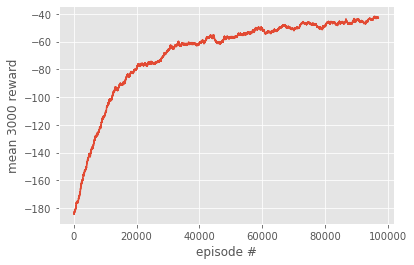

In [6]:
#train
'''
import gymnasium as gym
env = gym.make("LunarLander-v2", render_mode="human")
observation, info = env.reset(seed=42)
for _ in range(1000):
   action = env.action_space.sample()  # this is where you would insert your policy
   observation, reward, terminated, truncated, info = env.step(action)

   if terminated or truncated:
      observation, info = env.reset()

env.close()
'''
# 初始化环境参数
SIZE = 10
EPISODES = 100000
SHOW_EVERY = 3000

epsilon = 0.6 #选择随机概率
EPS_DECAY = 0.9998 #概率折扣

DISCOUNT = 0.95 #折扣 gamma
LEARNING_RATE = 0.3 #alpha

q_table_name = f'Q_table\qtable_1719578112.pickle'

env = envCube()
obs = env.reset()
q_table = env.init_q_table()

# train
episode_rewards = [] # 奖励序列
for episode in range(EPISODES): 
    done = False   

    # 显示图像 
    if(episode % SHOW_EVERY == 0):
        print(f'episode #{episode}, epsilon:{epsilon}')
        flag_show = False
        if(episode >= SHOW_EVERY):
            print(f'mean reward:{np.mean(episode_rewards[-SHOW_EVERY:])}')
            flag_show = True
    else:
        flag_show = False
    
    episode_reward = 0
    while not done:
        if np.random.random() > epsilon:
            action = np.argmax(q_table[obs]) #选择Q值最高动作
        else:
            action = np.random.randint(0, env.ACTION_SPACE_VALUES) #随机选择一个动作
            
        newObs, reward, done = env.step(action)
    
        # Update the Q_table----------------------
        current_q = q_table[obs][action]    # 当前动作、状态对应Q_value
        max_future_q = np.max(q_table[obs]) # 新状态最大Q_value

        if (reward == env.FOOD_REWARD):
            new_q = env.FOOD_REWARD
        else:
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT + max_future_q) 

        q_table[obs][action] = new_q
        obs = newObs
        # ---------------------------------
        
        if flag_show:
            env.render()
  
        episode_reward += reward
        
    if done:
        obs = env.reset()       
    episode_rewards.append(episode_reward)
    epsilon *= EPS_DECAY
    
cv2.destroyAllWindows()
#画曲线
moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode = 'valid')
print(len(moving_avg))
plt.plot([i for i in range(len(moving_avg))], moving_avg)
plt.xlabel('episode #')
plt.ylabel(f'mean {SHOW_EVERY} reward')
plt.show()

if not os.path.exists('Q_table'):
    os.makedirs('Q_table')
with open(f'Q_table\qtable_pro_{int(time.time())}.pickle', 'wb') as f:
    pickle.dump(q_table, f)


In [37]:
def test(q_table, episodes, show_enable=True):
    env = envCube()
    
    obs = env.reset()
    operations = []
    rewards = []
    for episode in range(episodes):
        done = False
        operation = 0
        episode_reward = 0

        while not done:
            action = np.argmax(q_table[obs])
            newObs, reward, done = env.step(action)
            obs = newObs
            operation += 1
            episode_reward += reward

            if show_enable:
                env.render()
              
        if done:
            print(f'episode: #{episode} reward:{episode_reward}  The number of operation:{operation}')
            obs = env.reset()
            operations.append(operation)
            rewards.append(episode_reward)

        cv2.waitKey(5000)
        cv2.destroyAllWindows()

    print(f'mean operations:{np.mean(operations[:])} mean reward:{np.mean(rewards[:])}')
        


In [39]:
with open('Q_table\qtable_pro_1720528349.pickle', 'rb') as f:
    q_table_save = pickle.load(f)
test(q_table_save, 20)

episode: #0 reward:-28  The number of operation:54
episode: #1 reward:-4  The number of operation:30
episode: #2 reward:22  The number of operation:4
episode: #3 reward:-200  The number of operation:200
episode: #4 reward:-3  The number of operation:29
episode: #5 reward:22  The number of operation:4
episode: #6 reward:-161  The number of operation:187
episode: #7 reward:-67  The number of operation:93
episode: #8 reward:-152  The number of operation:178
episode: #9 reward:-48  The number of operation:74
episode: #10 reward:2  The number of operation:24
episode: #11 reward:24  The number of operation:2
episode: #12 reward:20  The number of operation:6
episode: #13 reward:-84  The number of operation:110
episode: #14 reward:16  The number of operation:10
episode: #15 reward:-62  The number of operation:88
episode: #16 reward:-113  The number of operation:139
episode: #17 reward:-29  The number of operation:55
episode: #18 reward:-22  The number of operation:48
episode: #19 reward:-35  T